# Data Analysis Covid-19 in North Carolina Counties

In [1]:
# Dependencies
%matplotlib notebook
from census import Census
from config import (census_key, gkey)
import gmaps
import numpy as np
import pandas as pd
import requests
import time
from us import states
from scipy.stats import linregress
from matplotlib import pyplot as plt
from pprint import pprint

# Census API Key
c = Census(census_key)

## Generate Census Data

In [2]:
census_data = c.acs5.get(("NAME", "B01003_001E","B01002_001E", "B19013_001E","B19301_001E","B07013_002E"),
                         {'for': 'county:*','in': 'state:37'})

census_df = pd.DataFrame(census_data)
census_df

census_df = census_df.rename(columns={"B01003_001E": "Population",
                                      "B01002_001E": "Median Age",
                                      "B19013_001E": "Household Income",
                                      "B19301_001E": "Per Capita Income",
                                      "B07013_002E": "Householder Owner",
                                      "NAME": "County"})
census_df


# Add in Householder Owner Rate (Hoseholder Owner / Population)
census_df["Householder Owner Rate"] = 100 * \
    census_df["Householder Owner"].astype(
        int) / census_df["Population"].astype(int)

# Final DataFrame
census_df = census_df[["County", "Population", "Median Age", "Household Income", 
                       "Per Capita Income", "Householder Owner Rate", ]]

census_df["County"]= census_df["County"].str.split(",", n = 1, expand = True)

census_df["Population Formatted"] = census_df["Population"].map("{:,.0f}".format)
census_df["Household Income Formatted"] = census_df["Household Income"].map("${:,.2f}".format)
census_df["Per Capita Income Formatted"] = census_df["Per Capita Income"].map("${:,.2f}".format)
census_df["Householder Owner Rate Formatted"] = census_df["Householder Owner Rate"].map("%{:.1f}".format)

census_df['County'] = census_df['County'].str.replace(r'County', '').str.rstrip()
census_df

census_df = census_df.sort_values("County", ascending=True)

census_df = census_df.reset_index(drop=True)

# Visualize
print(len(census_df))
census_df.head()

100


,County,Population,Median Age,Household Income,Per Capita Income,Householder Owner Rate,Population Formatted,Household Income Formatted,Per Capita Income Formatted,Householder Owner Rate Formatted
0,Alamance,157844.0,39.7,44281.0,25157.0,64.182991,"157,844","$44,281.00","$25,157.00",%64.2
1,Alexander,37159.0,42.8,44523.0,22655.0,71.285557,"37,159","$44,523.00","$22,655.00",%71.3
2,Alleghany,10935.0,49.2,38944.0,21153.0,72.812071,"10,935","$38,944.00","$21,153.00",%72.8
3,Anson,25531.0,40.4,38123.0,19105.0,60.937684,"25,531","$38,123.00","$19,105.00",%60.9
4,Ashe,26833.0,47.2,40293.0,23650.0,73.197183,"26,833","$40,293.00","$23,650.00",%73.2


In [3]:
census_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   County                            100 non-null    object 
 1   Population                        100 non-null    float64
 2   Median Age                        100 non-null    float64
 3   Household Income                  100 non-null    float64
 4   Per Capita Income                 100 non-null    float64
 5   Householder Owner Rate            100 non-null    float64
 6   Population Formatted              100 non-null    object 
 7   Household Income Formatted        100 non-null    object 
 8   Per Capita Income Formatted       100 non-null    object 
 9   Householder Owner Rate Formatted  100 non-null    object 
dtypes: float64(5), object(5)
memory usage: 7.9+ KB


In [4]:
# Export to csv
census_df.to_csv("Census.csv", index=False, header=True)

## Generate Covid-19 Data

In [5]:
url="https://api.covid19api.com/dayone/country/united-states"
response = requests.get(url).json()
covid_df = pd.DataFrame(response)
covid_df
covid_df = covid_df.loc[(covid_df["Province"] == "North Carolina")]
covid_df

covid_df = covid_df.rename(columns={"City": "County",
                                    "CityCode": "Zipcode",
                                    "Lat": "Latitude",
                                    "Lon": "Longitude",})
                        
# Original DataFrame - to alllow for possible look at first occurance date
original_covid_df = covid_df[["County", "Zipcode", "Latitude", "Longitude", "Confirmed", "Deaths", "Recovered", "Active", "Date"]]                                    
covid_df.to_csv("All_Covid.csv", index=False, header=True)

# Final DataFrame
Max_date = original_covid_df["Date"].max()
covid_df = original_covid_df.loc[(covid_df["Date"] == Max_date)]
covid_df

covid_df = covid_df.sort_values("County", ascending=True)

covid_df = covid_df.reset_index(drop=True)

# Visualize
print(len(covid_df))
covid_df.head()


93


,County,Zipcode,Latitude,Longitude,Confirmed,Deaths,Recovered,Active,Date
0,Alamance,37001,36.04,-79.4,60,0,0,0,2020-04-22T00:00:00Z
1,Alexander,37003,35.92,-81.18,4,0,0,0,2020-04-22T00:00:00Z
2,Alleghany,37005,36.49,-81.13,2,0,0,0,2020-04-22T00:00:00Z
3,Anson,37007,34.97,-80.1,19,0,0,0,2020-04-22T00:00:00Z
4,Ashe,37009,36.43,-81.5,4,0,0,0,2020-04-22T00:00:00Z


In [6]:
covid_df[(covid_df["Deaths"] > 0)]

,County,Zipcode,Latitude,Longitude,Confirmed,Deaths,Recovered,Active,Date
6,Bertie,37015,36.07,-76.97,27,1,0,0,2020-04-22T00:00:00Z
8,Brunswick,37019,34.07,-78.23,38,2,0,0,2020-04-22T00:00:00Z
9,Buncombe,37021,35.61,-82.53,49,3,0,0,2020-04-22T00:00:00Z
10,Burke,37023,35.75,-81.71,83,8,0,0,2020-04-22T00:00:00Z
11,Cabarrus,37025,35.39,-80.55,232,7,0,0,2020-04-22T00:00:00Z
13,Carteret,37031,34.89,-76.54,27,3,0,0,2020-04-22T00:00:00Z
15,Catawba,37035,35.66,-81.21,47,1,0,0,2020-04-22T00:00:00Z
16,Chatham,37037,35.7,-79.26,135,6,0,0,2020-04-22T00:00:00Z
17,Cherokee,37039,35.13,-84.06,18,1,0,0,2020-04-22T00:00:00Z
20,Cleveland,37045,35.34,-81.55,45,2,0,0,2020-04-22T00:00:00Z


In [7]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   County     93 non-null     object
 1   Zipcode    93 non-null     object
 2   Latitude   93 non-null     object
 3   Longitude  93 non-null     object
 4   Confirmed  93 non-null     int64 
 5   Deaths     93 non-null     int64 
 6   Recovered  93 non-null     int64 
 7   Active     93 non-null     int64 
 8   Date       93 non-null     object
dtypes: int64(4), object(5)
memory usage: 6.7+ KB


In [8]:
# Export to csv
covid_df.to_csv("Covid.csv", index=False, header=True)

## Merged Data

In [9]:
# Merge the two data sets along County

merged_df = census_df.merge(covid_df, on="County",how="inner")

#merged_data = census_df.update(covid_df)

merged_df.head()

,County,Population,Median Age,Household Income,Per Capita Income,Householder Owner Rate,Population Formatted,Household Income Formatted,Per Capita Income Formatted,Householder Owner Rate Formatted,Zipcode,Latitude,Longitude,Confirmed,Deaths,Recovered,Active,Date
0,Alamance,157844.0,39.7,44281.0,25157.0,64.182991,"157,844","$44,281.00","$25,157.00",%64.2,37001,36.04,-79.4,60,0,0,0,2020-04-22T00:00:00Z
1,Alexander,37159.0,42.8,44523.0,22655.0,71.285557,"37,159","$44,523.00","$22,655.00",%71.3,37003,35.92,-81.18,4,0,0,0,2020-04-22T00:00:00Z
2,Alleghany,10935.0,49.2,38944.0,21153.0,72.812071,"10,935","$38,944.00","$21,153.00",%72.8,37005,36.49,-81.13,2,0,0,0,2020-04-22T00:00:00Z
3,Anson,25531.0,40.4,38123.0,19105.0,60.937684,"25,531","$38,123.00","$19,105.00",%60.9,37007,34.97,-80.1,19,0,0,0,2020-04-22T00:00:00Z
4,Ashe,26833.0,47.2,40293.0,23650.0,73.197183,"26,833","$40,293.00","$23,650.00",%73.2,37009,36.43,-81.5,4,0,0,0,2020-04-22T00:00:00Z


In [10]:
merged_df.to_csv("Merged_df.csv", index=False, header=True)

## Plotting Data

In [11]:
confirmed_df = merged_df.loc[(merged_df["Confirmed"] > 0)].sort_values('Population', ascending=True)
#confirmed_df.reset_index(inplace=True)
#print(type(confirmed_df["Population"][0]))
#confirmed_df["Population"] = confirmed_df["Population"].str.replace(",", "").astype(int)


In [12]:
confirmed_df.loc[(merged_df["County"] == "Mecklenburg")].head()

,County,Population,Median Age,Household Income,Per Capita Income,Householder Owner Rate,Population Formatted,Household Income Formatted,Per Capita Income Formatted,Householder Owner Rate Formatted,Zipcode,Latitude,Longitude,Confirmed,Deaths,Recovered,Active,Date
54,Mecklenburg,1034290.0,34.9,61695.0,35669.0,57.500798,"1,034,290","$61,695.00","$35,669.00",%57.5,37119,35.24,-80.83,1331,36,0,0,2020-04-22T00:00:00Z


<IPython.core.display.Javascript object>


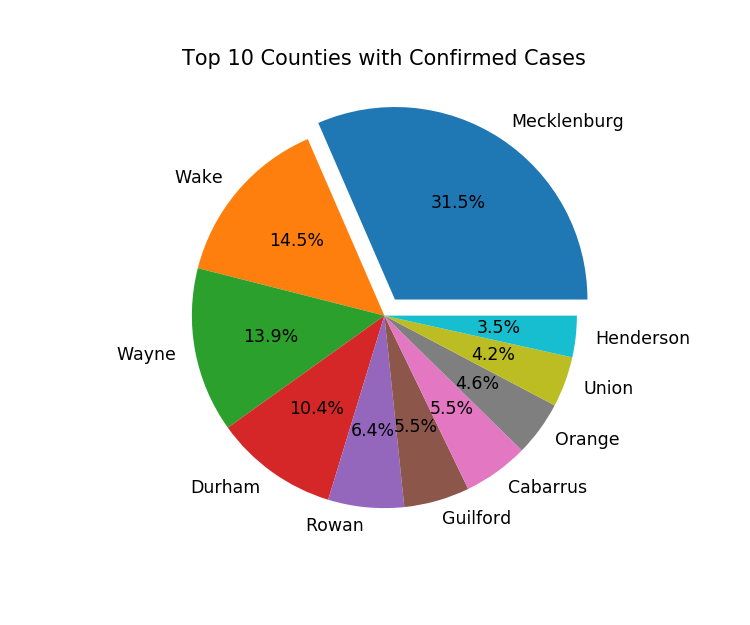

In [13]:
fig, ax = plt.subplots(figsize=(6,5))

Top_10_confirmed_data = confirmed_df.sort_values('Confirmed',ascending=False).head(10)
Top_10_confirmed_data
Confirmed_data =Top_10_confirmed_data['Confirmed']
Confirmed_data
labels= Top_10_confirmed_data['County']
explode = (0.1, 0,  0, 0, 0, 0, 0, 0, 0, 0) 
plt.pie(Confirmed_data,labels=labels,autopct="%1.1f%%", explode=explode)

ax.set_title("Top 10 Counties with Confirmed Cases")
plt.savefig("Top10ConfirmedCasesbyCounty.png")
plt.show()

<IPython.core.display.Javascript object>


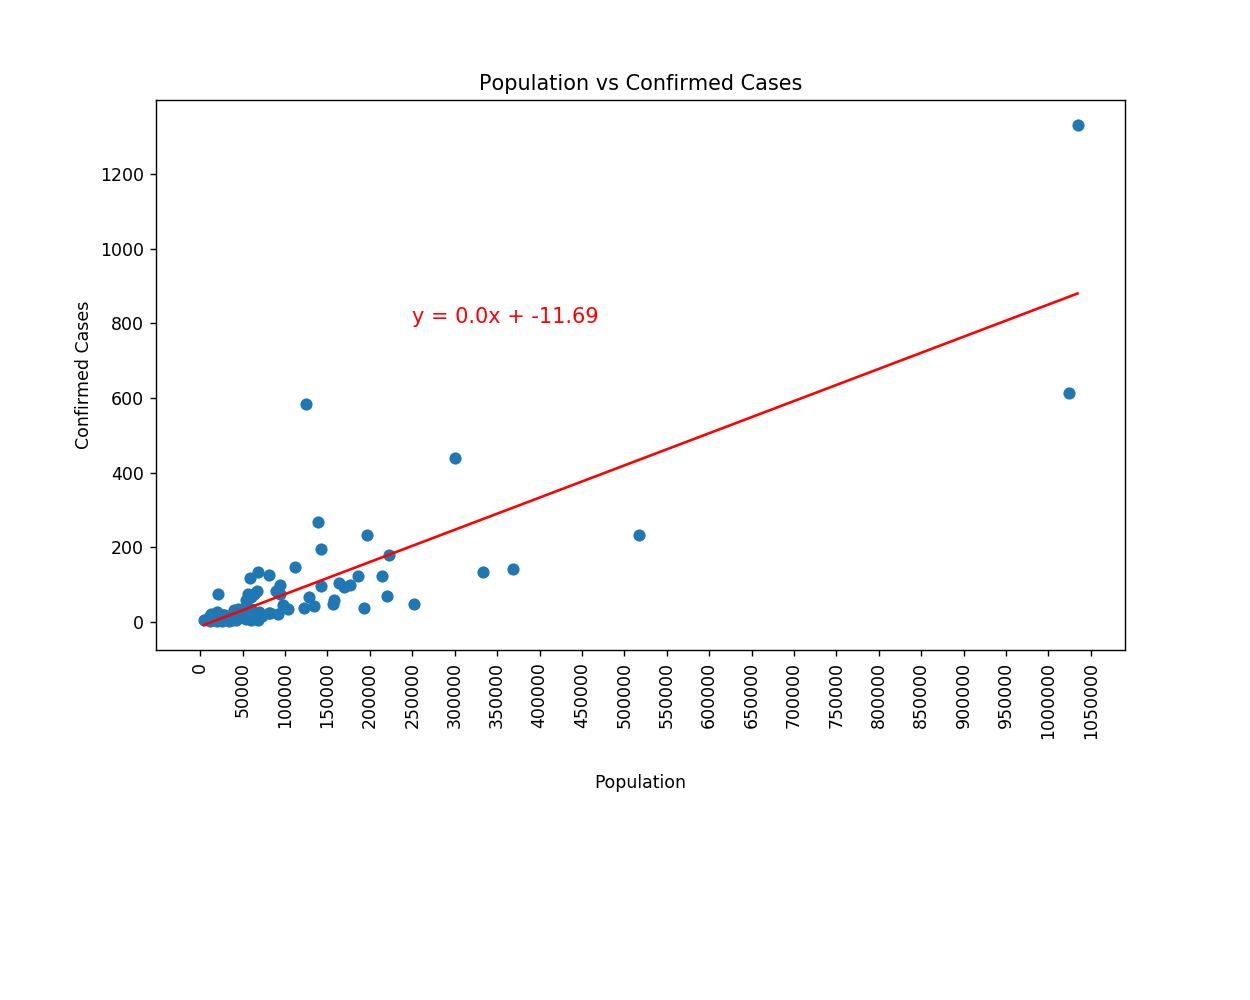

y = 0.0x + -11.69


In [26]:
confirmed_df.sort_values("Population", ascending=True, inplace=True)
confirmed_df = confirmed_df.reset_index(drop=True)
fig, ax = plt.subplots(figsize=(10,8))

series = confirmed_df["Population"]
#xticks = np.arange(confirmed_df["Population"].min(), confirmed_df["Population"].max() + 25000, 50000)
xticks = np.arange(0, series.max() + 25000, 50000)
ax.xaxis.set_ticks(xticks)
plt.scatter(series, confirmed_df.Confirmed)
ax.set_xlabel("Population", labelpad=20)
ax.set_ylabel("Confirmed Cases")
ax.set_title("Population vs Confirmed Cases")
plt.xlim = (series.min() -1, series.max() + 1)

fig.subplots_adjust(hspace=0, bottom=.35, top=.9 )
plt.xticks(rotation=90)

(slope, intercept, rvalue, pvalue, stderr) = linregress(series, confirmed_df["Confirmed"])
regress_values = series * slope + intercept
plt.plot(series,regress_values,"r-")
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
print(line_eq)
xplot_loc = 250000
yplot_loc = 800
plt.annotate(line_eq,(xplot_loc,yplot_loc),fontsize=12,color="red")
plt.savefig("PopulationVsConfirmedCases.png")

plt.show()

In [27]:
print(f"rValue={rvalue}, pValue={pvalue}, stderr{stderr}, r^2={rvalue**2}")

rValue=0.83235594287119, pValue=4.736737928583245e-25, stderr6.016289115529099e-05, r^2=0.6928164156329877


<IPython.core.display.Javascript object>


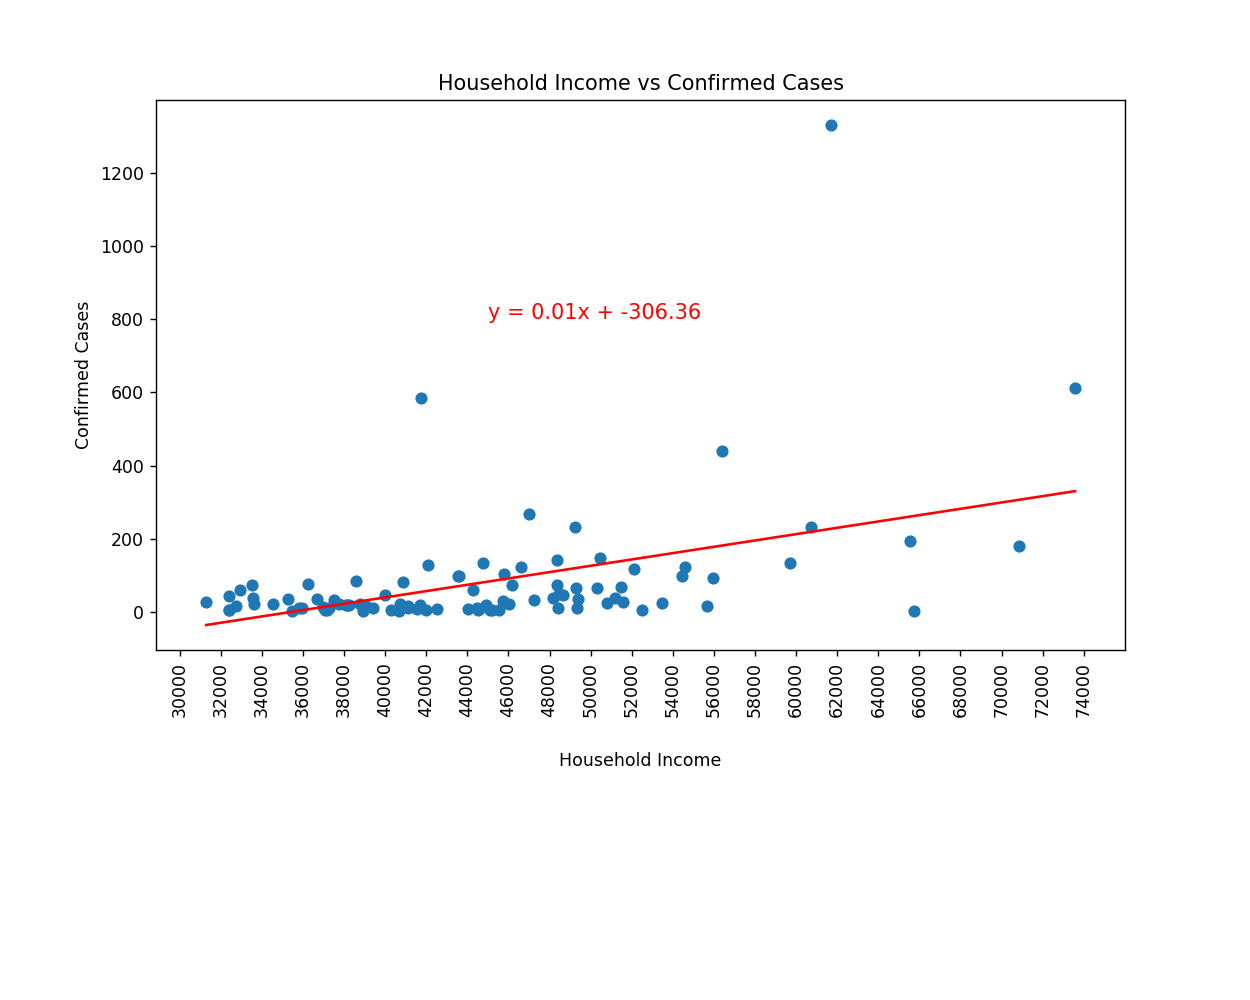

y = 0.01x + -306.36


In [29]:
confirmed_df.sort_values("Household Income", ascending=True, inplace=True)
confirmed_df = confirmed_df.reset_index(drop=True)
fig, ax = plt.subplots(figsize=(10,8))

series = confirmed_df["Household Income"]
#xticks = np.arange(confirmed_df["Population"].min(), confirmed_df["Population"].max() + 25000, 50000)
xticks = np.arange(0, series.max() + 2000, 2000)
ax.xaxis.set_ticks(xticks)
plt.scatter(series, confirmed_df.Confirmed)
ax.set_xlabel("Household Income", labelpad=20)
ax.set_ylabel("Confirmed Cases")
ax.set_title("Household Income vs Confirmed Cases")
plt.xlim = (series.min() -1, series.max() + 1)

fig.subplots_adjust(hspace=0, bottom=.35, top=.9 )
plt.xticks(rotation=90)

(slope, intercept, rvalue, pvalue, stderr) = linregress(series, confirmed_df["Confirmed"])
regress_values = series * slope + intercept
plt.plot(series,regress_values,"r-")
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
print(line_eq)
xplot_loc = 45000
yplot_loc = 800
plt.annotate(line_eq,(xplot_loc,yplot_loc),fontsize=12,color="red")
plt.savefig("HouseholdIncomeVsConfirmedCases.png")
plt.show()

In [31]:
print(f"rValue={rvalue}, pValue={pvalue}, stderr{stderr}, r^2={rvalue**2}")

rValue=0.448813763147382, pValue=6.4182000001078135e-06, stderr0.0018056703886351793, r^2=0.20143379399051434


<IPython.core.display.Javascript object>


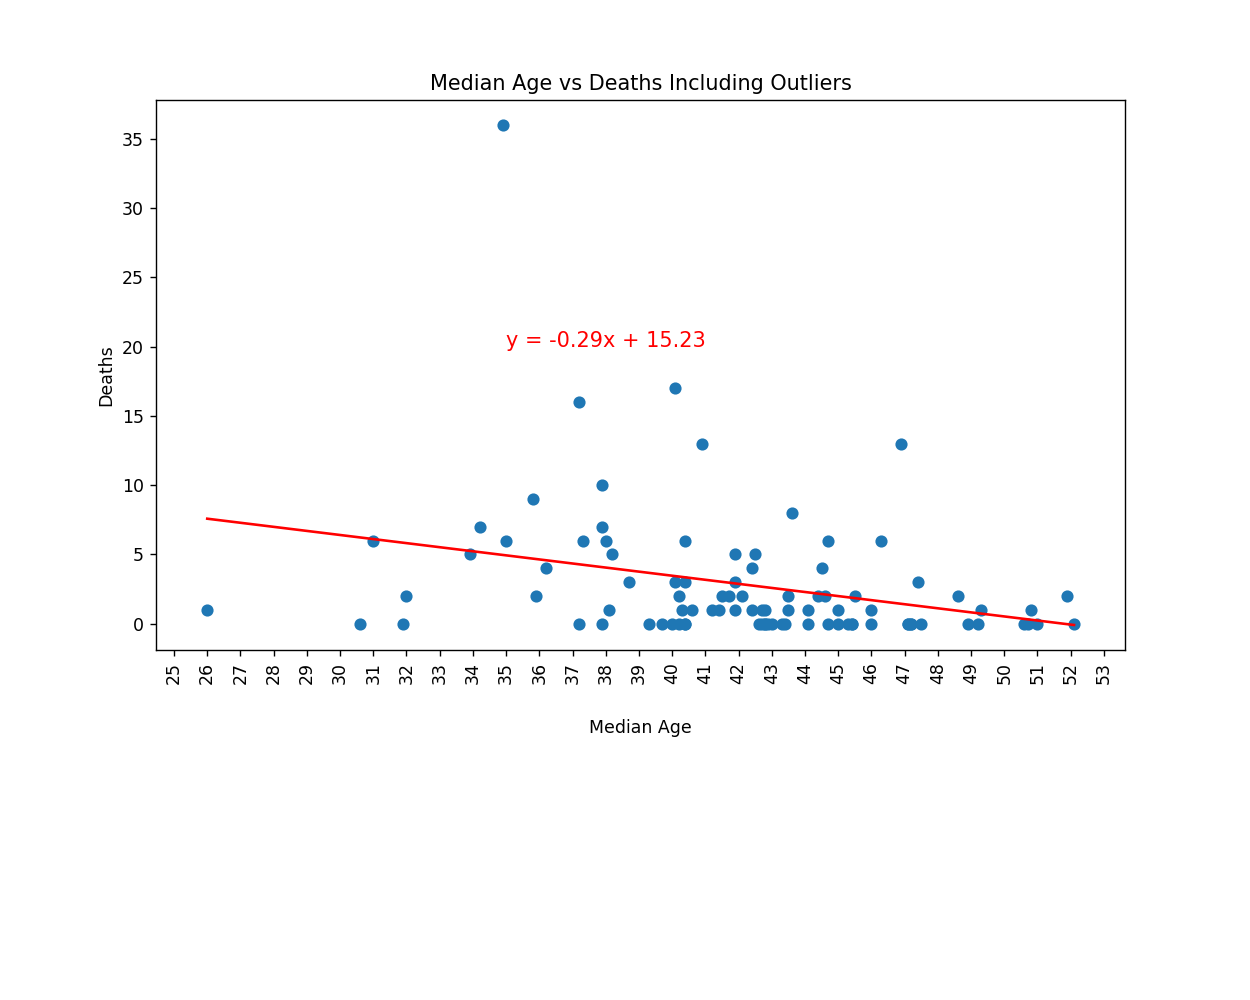

y = -0.29x + 15.23


In [25]:
confirmed_df.sort_values("Median Age", ascending=True, inplace=True)
confirmed_df = confirmed_df.reset_index(drop=True)
fig, ax = plt.subplots(figsize=(10,8))

series = confirmed_df["Median Age"]
#xticks = np.arange(confirmed_df["Population"].min(), confirmed_df["Population"].max() + 25000, 50000)
xticks = np.arange(0, series.max() + 2, 1)
ax.xaxis.set_ticks(xticks)
plt.scatter(series, confirmed_df.Deaths)
ax.set_xlabel("Median Age", labelpad=20)
ax.set_ylabel("Deaths")
ax.set_title("Median Age vs Deaths Including Outliers")
plt.xlim = (series.min() -1, series.max() + 1)

fig.subplots_adjust(hspace=0, bottom=.35, top=.9 )
plt.xticks(rotation=90)

(slope, intercept, rvalue, pvalue, stderr) = linregress(series, confirmed_df["Deaths"])
regress_values = series * slope + intercept
plt.plot(series,regress_values,"r-")
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
print(line_eq)
xplot_loc = 35
yplot_loc = 20
plt.annotate(line_eq,(xplot_loc,yplot_loc),fontsize=12,color="red")

plt.savefig("MedianAgeVsDeaths.png")

plt.show()



In [24]:
print(f"rValue={rvalue}, pValue={pvalue}, stderr{stderr}, r^2={rvalue**2}")

rValue=-0.29780077462486276, pValue=0.0037420050508202595, stderr0.09882361237283085, r^2=0.0886853013671683


In [19]:
quartiles = confirmed_df.Confirmed.quantile([.25, .5, .75])
print(quartiles)

lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)

print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")


outliers = confirmed_df.loc[(confirmed_df["Confirmed"] < lower_bound) | 
                              (confirmed_df["Confirmed"] > upper_bound)]


confirmed_without_outliers = pd.merge(confirmed_df,outliers, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
outliers[["County", "Population", "Confirmed", "Deaths"]]

0.25    11.0
0.50    27.0
0.75    83.0
Name: Confirmed, dtype: float64
Values below -97.0 could be outliers.
Values above 191.0 could be outliers.


,County,Population,Confirmed,Deaths
39,Wayne,124496.0,585,6
60,Rowan,138940.0,269,17
68,Guilford,517197.0,233,16
85,Durham,300865.0,439,6
87,Cabarrus,196716.0,232,7
88,Mecklenburg,1034290.0,1331,36
89,Orange,141812.0,195,7
92,Wake,1023811.0,613,9


<IPython.core.display.Javascript object>


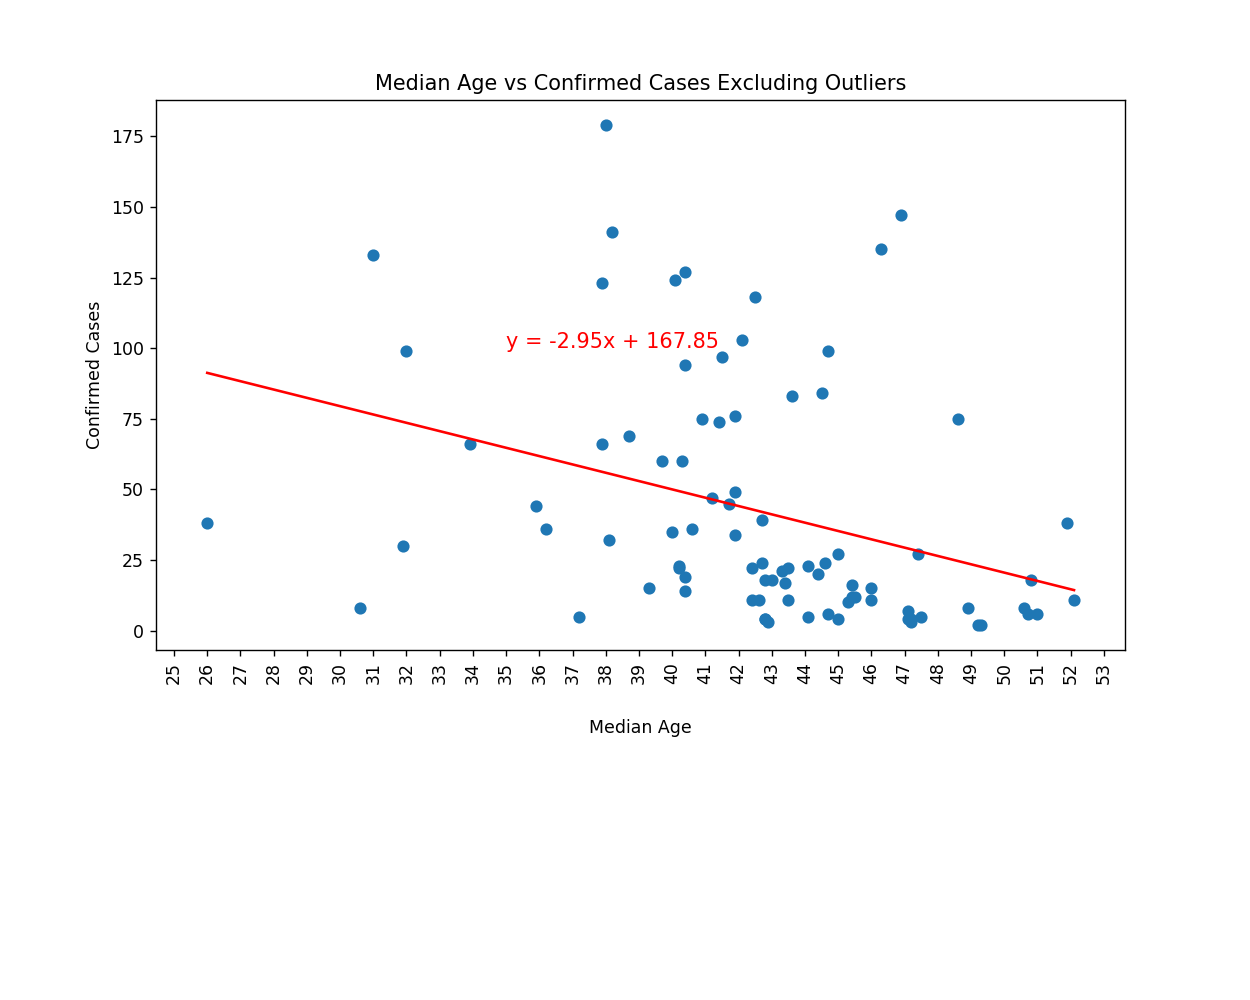

y = -2.95x + 167.85


In [32]:
confirmed_without_outliers.sort_values("Median Age", ascending=True, inplace=True)
confirmed_without_outliers = confirmed_without_outliers.reset_index(drop=True)
fig, ax = plt.subplots(figsize=(10,8))

series = confirmed_without_outliers["Median Age"]
#xticks = np.arange(confirmed_df["Population"].min(), confirmed_df["Population"].max() + 25000, 50000)
xticks = np.arange(0, series.max() + 2, 1)
ax.xaxis.set_ticks(xticks)
plt.scatter(series, confirmed_without_outliers.Confirmed)
ax.set_xlabel("Median Age", labelpad=20)
ax.set_ylabel("Confirmed Cases")
ax.set_title("Median Age vs Confirmed Cases Excluding Outliers")
plt.xlim = (series.min() -1, series.max() + 1)

fig.subplots_adjust(hspace=0, bottom=.35, top=.9 )
plt.xticks(rotation=90)

(slope, intercept, rvalue, pvalue, stderr) = linregress(series, confirmed_without_outliers["Confirmed"])
regress_values = series * slope + intercept
plt.plot(series,regress_values,"r-")
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
print(line_eq)
xplot_loc = 35
yplot_loc = 100
plt.annotate(line_eq,(xplot_loc,yplot_loc),fontsize=12,color="red")

plt.savefig("MedianAgeVsConfirmed.png")

plt.show()

In [33]:
print(f"rValue={rvalue}, pValue={pvalue}, stderr{stderr}, r^2={rvalue**2}")

rValue=-0.33994985228818003, pValue=0.0014568444399601737, stderr0.8946460443440151, r^2=0.11556590207075543


<IPython.core.display.Javascript object>


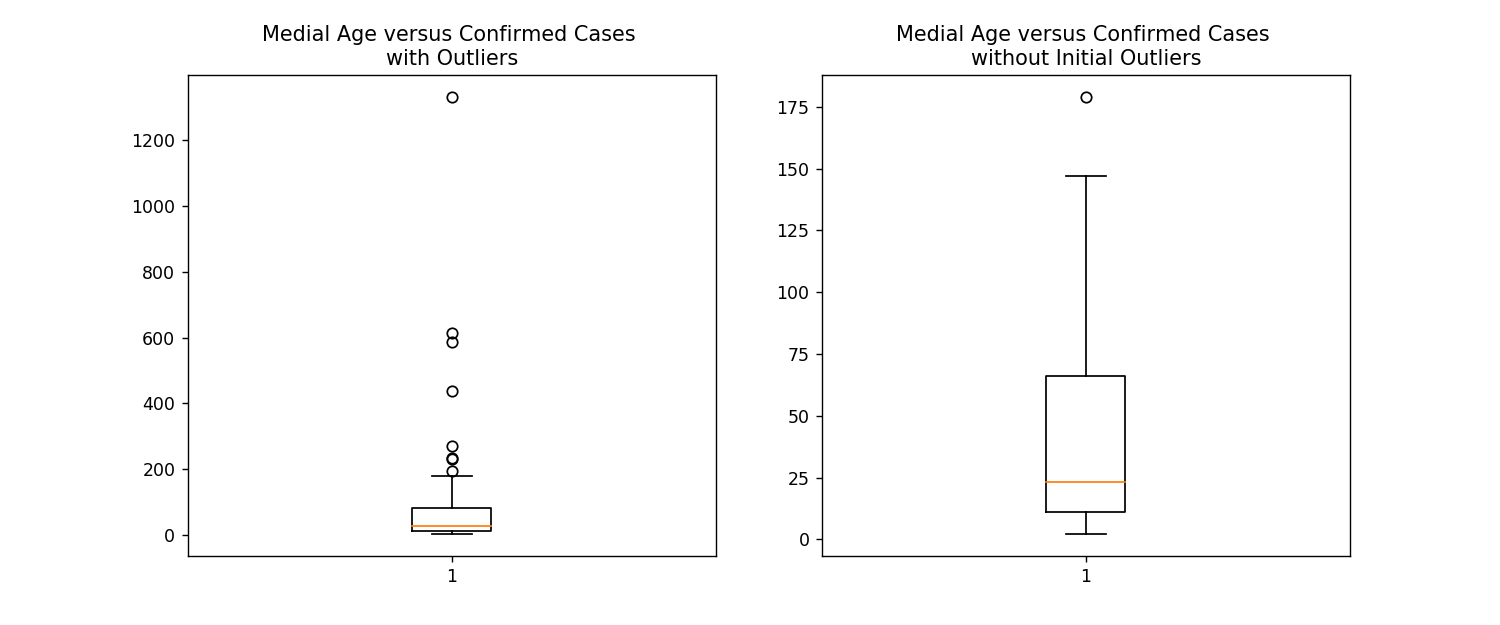

In [49]:
fig, axes = plt.subplots(1,2, figsize=(12,5))

axes[0].boxplot(confirmed_df.Confirmed)
axes[0].set_title("Medial Age versus Confirmed Cases \nwith Outliers")

axes[1].boxplot(confirmed_without_outliers.Confirmed)
axes[1].set_title("Medial Age versus Confirmed Cases \nwithout Initial Outliers")
plt.savefig("MedianAgeVsConfirmedBoxPlot.png")

In [46]:
# Build a scatter plot for each data type

plt.scatter(merged_df['County'], merged_df['Confirmed'], marker="o", edgecolors="black", facecolors="aqua")

# Incorporate de other graph properties
plt.title(f'Confirmed Cases by County % {time.strftime("%m/%d/%Y")}')
plt.ylabel("Confirmed")
plt.xlabel("County")
plt.grid(True)
plt.xlim(0,len('Count'))
plt.ylim(0,1400)

# Save the figure
plt.savefig("ConfirmedCasesbyCounty.png")

# Show plot
plt.show()

TypeError: 'str' object is not callable

In [28]:
# Create a Scatter Plot for temperature vs latitude
x_values = merged_df['County']
y_values = merged_df['Confirmed']
plt.scatter(x_values,y_values)
plt.xlabel('County')
plt.ylabel('Confirmed Cases')
plt.show()